# Convolutional Neural Network applied to Transient Detection

We star by reading the data

In [ ]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#pkl_data = np.load("data/HiTS_data.pkl", encoding='bytes')
pkl_data = np.load(gzip.GzipFile("all_chunks/chunk_188_5000.pkl.gz", 'rb'), encoding='bytes')
#pkl_data = np.load("/Users/guille/Dropbox/git/Deep-HiTS/data/test_data/chunk_101_5000.pkl")
print(pkl_data.keys())
print(pkl_data[b'diff_images'].shape)

Now we arrange the data so Keras can handle it

In [4]:
N_data = pkl_data[b'diff_images'].shape[0]
print(N_data)
X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
             pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
             pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
             pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
X = np.swapaxes(X, 0, 1)

Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
print(X.shape, Y.shape)
print(np.mean(Y[:,0]), np.mean(Y[:,1]))

5030
(5030, 4, 21, 21) (5030, 2)
0.5 0.5


Let's plot a couple of stamps

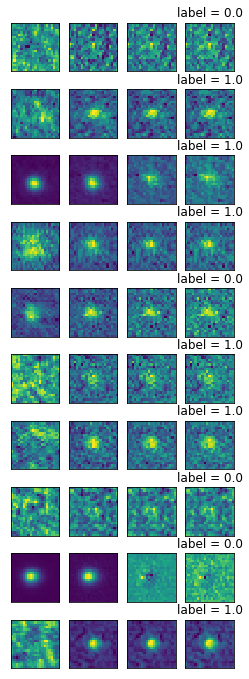

In [28]:
N_plot = 10

plt.clf()
fig, axes = plt.subplots(N_plot, 4, figsize=(4, 12),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(N_plot):
    axes.flat[4*i].imshow(X[i][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X[i][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X[i][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X[i][3], interpolation = "none")
    #axes.flat[4*i + 3].imshow(pkl_data['diff_images'][i].reshape((21, 21)), interpolation = "nearest")

    axes.flat[4*i + 3].set_title ("label = " + str(Y[i][1]))
plt.show()

We split the data into training, and test set.

In [6]:
N_train = int(N_data * 0.9)

X_train, Y_train = X[:N_train], Y[:N_train]
X_test, Y_test = X[N_train:], Y[N_train:]

print("Train: ", X_train.shape, Y_train.shape)
print("Test: ", X_test.shape, Y_test.shape)

Train:  (4527, 4, 21, 21) (4527, 2)
Test:  (503, 4, 21, 21) (503, 2)


Put data loader into a function, break up potentially into train/valid/test subsets...

In [116]:
def load_pkl_data(chunk_num, split_frac=(0.8, 0.9), verbose=False):
    fname = 'all_chunks/chunk_%d_5000.pkl.gz' % chunk_num
    pkl_data = np.load(gzip.GzipFile(fname, 'rb'), encoding='bytes')
    if False:
        print(pkl_data.keys())
        print(pkl_data[b'diff_images'].shape)
    
    N_data = pkl_data[b'diff_images'].shape[0]
    if False:
        print(N_data)
    X = np.array([pkl_data[b'temp_images'].reshape((N_data, 21, 21)), 
                 pkl_data[b'sci_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'diff_images'].reshape((N_data, 21, 21)),
                 pkl_data[b'SNR_images'].reshape((N_data, 21, 21))])
    X = np.swapaxes(X, 0, 1)

    Y = np.array([np.logical_not(pkl_data[b'labels']), pkl_data[b'labels']]).transpose()
    if False:
        print(X.shape, Y.shape)
        
    N_train = int(N_data * split_frac[0])
    N_valid = 0
    if split_frac[0] < 1.0:
        N_valid = int(N_data * split_frac[1])
    N_test = 0
    if split_frac[1] < 1.0:
        N_test  = int(N_data * 1.0)

    X_train, Y_train = X[:N_train], Y[:N_train]
    X_valid = Y_valid = None
    if N_valid > 0:
        X_valid, Y_valid = X[N_train:N_valid], Y[N_train:N_valid]
    X_test = Y_test = None
    if N_test > 0:
        X_test, Y_test = X[N_valid:N_test], Y[N_valid:N_test]

    if verbose:
        print(np.mean(Y[:,0]), np.mean(Y[:,1]))
        print("Train: ", X_train.shape, Y_train.shape)
        if N_valid > 0:
            print("Valid: ", X_valid.shape, Y_valid.shape)
        if N_test > 0:
            print("Test: ", X_test.shape, Y_test.shape)
        
    return (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test)

In [29]:
(X_train, Y_train), (X_test, Y_test), _ = load_pkl_data(188, (0.9, 1.0), verbose=True)

0.5 0.5
Train:  (4527, 4, 21, 21) (4527, 2)
Valid:  (503, 4, 21, 21) (503, 2)


We create a Keras sequential model and compile it.

In [96]:
from IPython.display import SVG
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.vis_utils import plot_model, model_to_dot

# set dimensions ordering (depth as index 1)
import keras
keras.backend.set_image_dim_ordering('th')

def make_model(compile=True, epochs=100, lrate=0.01, decay=None):
    model = Sequential()
    model.add(ZeroPadding2D((3, 3), input_shape = (4, 21, 21)))
    model.add(Convolution2D(32, (4, 4), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    if epochs <= 2:
        model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    if epochs <= 2:
        model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    if compile:
        # model.compile(loss='mean_squared_error',
        #       optimizer='sgd', metrics=['accuracy'])

        # initiate RMSprop optimizer (OLD)
        #opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

        # Compile model
        #epochs = 25
        #lrate = 0.01
        if decay is None:
            if epochs > 2:
                decay = lrate/epochs
            else:
                decay = lrate/100.
        opt = keras.optimizers.SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)

        # Let's train the model using RMSprop
        model.compile(loss='mean_squared_error', #categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy'])

    return model

In [97]:
epochs = 25
model = make_model(epochs=25)

Let's plot the model

To get this to plot, need to install (via pip --user or conda):
    
    1. graphviz
    2. pydot-ng

In [ ]:
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

In [77]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_76 (ZeroPaddi (None, 4, 27, 27)         0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 32, 24, 24)        2080      
_________________________________________________________________
zero_padding2d_77 (ZeroPaddi (None, 32, 26, 26)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 12, 12)        0         
_________________________________________________________________
zero_padding2d_78 (ZeroPaddi (None, 32, 14, 14)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 12, 12)        18496     
__________

Now, we fit our model to the training data-set

Try with data augmentation...

First break up data into train/cross-validation/test sets...

TBD: probably want to shuffle the data too.

In [83]:
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_pkl_data(188, verbose=True)

0.5 0.5
Train:  (4024, 4, 21, 21) (4024, 2)
Valid:  (503, 4, 21, 21) (503, 2)
Test:  (503, 4, 21, 21) (503, 2)


In [98]:
seed = 666
#batch_size = 32
#epochs = 25   # Probably want to stop around 75 but now we have auto-stopping

In [107]:
def run_model(model, train, valid, epochs=25, batch_size=32, data_augmentation=True, 
              patience=5, **kwargs):
    X_train, Y_train = train
    X_valid, Y_valid = valid
    
    from keras.callbacks import EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

    if not data_augmentation:
        if epochs > 2:
            print('Not using data augmentation.')
        histry = model.fit(X_train, Y_train, batch_size=batch_size, 
                  epochs=epochs, validation_data=(X_valid, Y_valid),
                  shuffle=True, callbacks=[early_stopping], **kwargs)
    else:
        if epochs > 2:
            print('Using real-time data augmentation.')
        from keras.preprocessing.image import ImageDataGenerator
        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=True)  # randomly flip images

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        # datagen.fit(X_train)  # so not needed.

        # Fit the model on the batches generated by datagen.flow().
        histry = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size), 
                            epochs=epochs, validation_data=(X_valid, Y_valid),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            callbacks=[early_stopping], **kwargs) 
        
    return model, histry

In [100]:
np.random.seed(seed)
model = make_model()
model, histry = run_model(model, (X_train, Y_train), (X_valid, Y_valid), data_augmentation=False)

Not using data augmentation.
Train on 4097 samples, validate on 512 samples
Epoch 1/25
4097/4097 [==============================] - 31s - loss: 0.0681 - acc: 0.9216 - val_loss: 0.0814 - val_acc: 0.9062
Epoch 2/25
4097/4097 [==============================] - 33s - loss: 0.0473 - acc: 0.9475 - val_loss: 0.1111 - val_acc: 0.8770
Epoch 3/25
4097/4097 [==============================] - 29s - loss: 0.0312 - acc: 0.9651 - val_loss: 0.0788 - val_acc: 0.9160
Epoch 4/25
4097/4097 [==============================] - 30s - loss: 0.0294 - acc: 0.9690 - val_loss: 0.0582 - val_acc: 0.9375
Epoch 5/25
4097/4097 [==============================] - 29s - loss: 0.0214 - acc: 0.9758 - val_loss: 0.0380 - val_acc: 0.9609
Epoch 6/25
4097/4097 [==============================] - 30s - loss: 0.0225 - acc: 0.9746 - val_loss: 0.0645 - val_acc: 0.9277
Epoch 7/25
4097/4097 [==============================] - 29s - loss: 0.0241 - acc: 0.9739 - val_loss: 0.0379 - val_acc: 0.9570
Epoch 8/25
4097/4097 [====================

In [101]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

512/513 [============================>.] - ETA: 0sTest loss: 0.00942932225221
Test accuracy: 0.990253411306


In [108]:
np.random.seed(seed)
model = make_model()
model, histry = run_model(model, (X_train, Y_train), (X_valid, Y_valid), data_augmentation=True,
                         patience=10)

Using real-time data augmentation.
Epoch 1/25
128/128 [==============================] - 28s - loss: 0.0505 - acc: 0.9380 - val_loss: 0.0478 - val_acc: 0.9395
Epoch 2/25
128/128 [==============================] - 27s - loss: 0.0280 - acc: 0.9685 - val_loss: 0.0389 - val_acc: 0.9570
Epoch 3/25
128/128 [==============================] - 28s - loss: 0.0255 - acc: 0.9717 - val_loss: 0.0551 - val_acc: 0.9355
Epoch 4/25
128/128 [==============================] - 28s - loss: 0.0260 - acc: 0.9717 - val_loss: 0.0535 - val_acc: 0.9434
Epoch 5/25
128/128 [==============================] - 30s - loss: 0.0201 - acc: 0.9780 - val_loss: 0.0433 - val_acc: 0.9531
Epoch 6/25
128/128 [==============================] - 29s - loss: 0.0234 - acc: 0.9734 - val_loss: 0.0365 - val_acc: 0.9570
Epoch 7/25
128/128 [==============================] - 28s - loss: 0.0187 - acc: 0.9792 - val_loss: 0.0362 - val_acc: 0.9629
Epoch 8/25
128/128 [==============================] - 28s - loss: 0.0239 - acc: 0.9734 - val_loss

In [109]:
score = model.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

512/513 [============================>.] - ETA: 0sTest loss: 0.00958487369713
Test accuracy: 0.990253411306


In [110]:
from sklearn import metrics
pred = model.predict_classes(X_test)
print(metrics.classification_report(Y_test[:,1].astype(int), pred))

512/513 [============================>.] - ETA: 0s             precision    recall  f1-score   support

          0       0.99      0.99      0.99       251
          1       0.99      0.99      0.99       262

avg / total       0.99      0.99      0.99       513



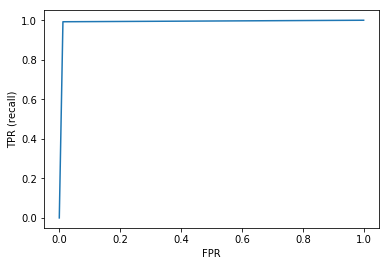

In [111]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')

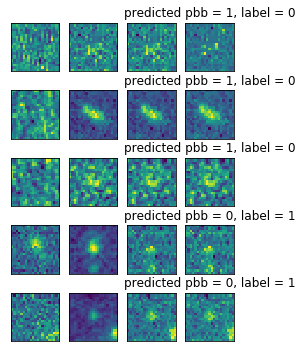

In [112]:
ypred = pred
ytest = Y_test[:, 1].astype(int)

N_plot = 10
only_plot_wrong = True
if not only_plot_wrong:
    plot_inds = range(N_plot)
else:
    plot_inds = np.where(ypred != ytest)[0]
    if len(plot_inds) > N_plot:
        plot_inds = plot_inds[:N_plot]
N_plot = len(plot_inds)

plt.clf()
fig, axes = plt.subplots(N_plot, 4, figsize=(4, N_plot*1.2),
                        subplot_kw={'xticks': [], 'yticks': []})
i = 0
for ind in plot_inds:
    axes.flat[4*i].imshow(X_test[ind][0], interpolation = "none")
    axes.flat[4*i + 1].imshow(X_test[ind][1], interpolation = "none")
    axes.flat[4*i + 2].imshow(X_test[ind][2], interpolation = "none")
    axes.flat[4*i + 3].imshow(X_test[ind][3], interpolation = "none")

    axes.flat[4*i + 3].set_title ("predicted pbb = " + str(np.round(ypred[ind], 2)) + 
                                  ", label = " + str(ytest[ind]))
    i += 1
plt.show()

Now try fitting a large number of data in batches:

In [93]:
n_data = 100  # number of datasets to run
seed = 666
batch_size = 32
epochs = 1  # 10   # Probably want to stop around 25 but now we have auto-stopping

In [94]:
np.random.seed(seed)
model = make_model()

for iter in range(100:)
    for d in range(n_data):
        (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = load_pkl_data(d)
        _, history = run_model(model, (X_train, Y_train), (X_valid, Y_valid), 
                  data_augmentation=True, verbose=0)
        score = model.evaluate(X_test, Y_test, verbose=0)
        print('Iter %d, Dataset %d: Test loss = %f; Test accuracy = %f' % (iter, d, score[0], score[1]))
        if iter > 0 and iter % 10 == 0:
            model.save('models/CNN_HiTS_demo_big_%02d.hdf5' % iter)

Dataset 0: Test loss = 0.020522; Test accuracy = 0.977011
Dataset 1: Test loss = 0.021069; Test accuracy = 0.978261
Dataset 2: Test loss = 0.047351; Test accuracy = 0.952096
Dataset 3: Test loss = 0.016788; Test accuracy = 0.986193
Dataset 4: Test loss = 0.014735; Test accuracy = 0.984095
Dataset 5: Test loss = 0.025702; Test accuracy = 0.968992
Dataset 6: Test loss = 0.014422; Test accuracy = 0.982143
Dataset 7: Test loss = 0.035030; Test accuracy = 0.956436
Dataset 8: Test loss = 0.033313; Test accuracy = 0.962151
Dataset 9: Test loss = 0.017067; Test accuracy = 0.984032
Dataset 10: Test loss = 0.006057; Test accuracy = 0.992395
Dataset 11: Test loss = 0.015210; Test accuracy = 0.984586
Dataset 12: Test loss = 0.027590; Test accuracy = 0.968064
Dataset 13: Test loss = 0.026422; Test accuracy = 0.970120
Dataset 14: Test loss = 0.010145; Test accuracy = 0.990291
Dataset 15: Test loss = 0.015365; Test accuracy = 0.984000
Dataset 16: Test loss = 0.009928; Test accuracy = 0.988350
Dataset

In [95]:
model.save('models/CNN_HiTS_demo_big_FINAL.hdf5')

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test[:,1].astype(int), pred)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('FPR'); plt.ylabel('TPR (recall)')